<a href="https://colab.research.google.com/github/litbe/Python/blob/master/SQLInjectionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sample. 
https://github.com/oreilly-japan/ml-security-jp/blob/master/ch07/Chapter7.ipynb  


https://github.com/Morzeux/HttpParamsDataset

In [1]:
import pandas as pd
df = pd.read_csv('./payload_train.csv')

In [2]:
print(df)

                                                 payload  ...  label
0                                         c/ caridad s/n  ...   norm
1                                           campello, el  ...   norm
2                                       1442431887503330  ...   norm
3                                                  nue37  ...   norm
4                                         tufts3@joll.rs  ...   norm
...                                                  ...  ...    ...
20707  <!--#exec cmd="/bin/echo '<script src'"--><!--...  ...   anom
20708  <head><meta http-equiv="content-type" content=...  ...   anom
20709  <script a=">" id=xss src="http://ha.ckers.org/...  ...   anom
20710  <script "a='>'" id=xss src="http://ha.ckers.or...  ...   anom
20711  <script a=`>` id=xss src="http://ha.ckers.org/...  ...   anom

[20712 rows x 4 columns]


In [3]:
import numpy as np
import pandas as pd

#HTTP query entropy
def H_entropy(x):
  prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x))]
  H = - sum([p * np.log2(p) for p in prob])
  return H

In [4]:
#normal label
df_norm = df[df.attack_type == 'norm']

#list
norm_entropies = []

# payload
for i in df_norm['payload']:
  norm_entropies.append(H_entropy(i))

In [5]:
#entropy
sum(norm_entropies) / len(norm_entropies)

2.7658075808985836

In [6]:
#sqli label
df_sqli = df[df.attack_type == 'sqli']

#list
sqli_entropies = []

# payload
for i in df_sqli['payload']:
  sqli_entropies.append(H_entropy(i))

In [7]:
#entropy
sum(sqli_entropies) / len(sqli_entropies)

4.289379819336267

<function matplotlib.pyplot.show>

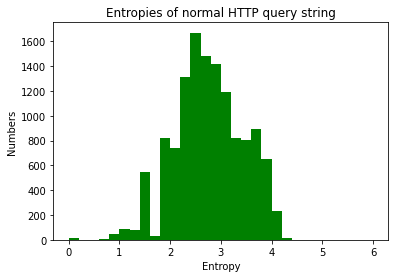

In [8]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

ax.set_title('Entropies of normal HTTP query string')
ax.set_xlabel('Entropy')
ax.set_ylabel('Numbers')

plt.hist(norm_entropies, bins=30, range=(0,6), color='green')
plt.show

<function matplotlib.pyplot.show>

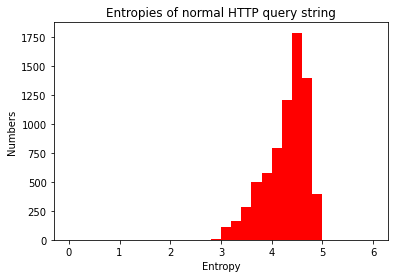

In [9]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

ax.set_title('Entropies of normal HTTP query string')
ax.set_xlabel('Entropy')
ax.set_ylabel('Numbers')

plt.hist(sqli_entropies, bins=30, range=(0,6), color='red')
plt.show

In [10]:
df_sqli = df[df.attack_type == 'sqli']
df_sqli

,payload,length,attack_type,label
291,1' where 6406=6406;select count(*) from rdb$fi...,115,sqli,anom
292,1) and 8514=(select count(*) from domain.domai...,111,sqli,anom
293,1) where 7956=7956 or sleep(5)#,31,sqli,anom
294,-7387'))) order by 1--,22,sqli,anom
295,"1))) union all select null,null,null#",37,sqli,anom
...,...,...,...,...
20360,"1%"")) and elt(4249=4249,7259) and ((""%""=""",41,sqli,anom
20361,-7773' or 5903=('qqpjq'||(select case 5903 whe...,99,sqli,anom
20362,"1"" order by 1--",15,sqli,anom
20363,"1' procedure analyse(extractvalue(5840,concat(...",149,sqli,anom


In [11]:
print('{:.2%}'.format(
    df_sqli['payload'].str.contains('\)').sum() \
    / len(df_sqli['payload'])
    )
)

90.91%


In [12]:
df_norm = df[df.attack_type == 'norm']

print('{:.2%}'.format(
    df_norm['payload'].str.contains('\)').sum() \
    / len(df_norm['payload'])
    )
)

0.01%


In [13]:
# Extend the dataset to add add new features
def func_preprocessing(df):
  train_rows = ((df.attack_type == 'norm') | (df.attack_type == 'sqli'))
  df = df[train_rows]

  entropies = []
  closing_parenthesis = []

  # Extract HTTP query string from pyaload string and let it be processed
  for i in df['payload']:
    # Calculation of entropy
    entropies.append(H_entropy(i))
    # ')'detection
    if i.count(')'):
      closing_parenthesis.append(1)
    else :
      closing_parenthesis.append(0)
  # Add dataset
  df = df.assign(entropy=entropies)
  df = df.assign(closing_parenthesis=closing_parenthesis)

  rep = df.label.replace({"norm":0, "anom":1})
  df = df.assign(label=rep)

  return df


In [14]:
df = func_preprocessing(df)
df

,payload,length,attack_type,label,entropy,closing_parenthesis
0,c/ caridad s/n,14,norm,0,3.093069,0
1,"campello, el",12,norm,0,3.022055,0
2,1442431887503330,16,norm,0,2.827820,0
3,nue37,5,norm,0,2.321928,0
4,tufts3@joll.rs,14,norm,0,3.378783,0
...,...,...,...,...,...,...
20360,"1%"")) and elt(4249=4249,7259) and ((""%""=""",41,sqli,1,4.064392,1
20361,-7773' or 5903=('qqpjq'||(select case 5903 whe...,99,sqli,1,4.718866,1
20362,"1"" order by 1--",15,sqli,1,3.189898,0
20363,"1' procedure analyse(extractvalue(5840,concat(...",149,sqli,1,4.641613,1


SQL injection Detector

In [21]:
test_data = pd.read_csv('./payload_test.csv')
test_data = func_preprocessing(test_data)

# Extract of features
df_x = df[['length', 'entropy', 'closing_parenthesis']]
test_x = test_data[['length', 'entropy', 'closing_parenthesis']]

# Extract labels
df_y = df[['label']]
test_y = test_data[['label']]

X_all = pd.concat([df_x, test_x])
y_all = pd.concat([df_y, test_y])

print(X_all)
print(y_all)

       length   entropy  closing_parenthesis
0          14  3.093069                    0
1          12  3.022055                    0
2          16  2.827820                    0
3           5  2.321928                    0
4          14  3.378783                    0
...       ...       ...                  ...
10176     113  4.422041                    1
10177     113  4.514233                    1
10178     136  4.630369                    1
10179     111  4.539371                    1
10180      53  4.130354                    1

[30156 rows x 3 columns]
       label
0          0
1          0
2          0
3          0
4          0
...      ...
10176      1
10177      1
10178      1
10179      1
10180      1

[30156 rows x 1 columns]


In [16]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.1 MB/s 
     |████████████████████████████████| 210 kB 53.0 MB/s 
     |████████████████████████████████| 80 kB 7.5 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 112 kB 51.6 MB/s 
     |████████████████████████████████| 149 kB 46.7 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=8ca39d607b30fe67e3a7587587e2072d64b5ea9c7596ad8828de42f98a552819
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = \
train_test_split(X_all, y_all, test_size=0.2, shuffle=True, random_state=101)

class Objective_DTC:
    def __init__(self, X, y):
        # 変数 X,y の初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # チューニング対象のハイパーパラメータの設定
        params ={
        'criterion': trial.suggest_categorical(
            'criterion', 
            ['gini', 'entropy']
            ),
        'max_depth': trial.suggest_int(
            'max_depth', 
            1, 64
            )
        }
        model = DecisionTreeClassifier(**params)

        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                scoring='accuracy',
                                n_jobs=-1)
        # 交差検証結果の平均を戻り値に設定
        return scores['test_score'].mean()

objective = Objective_DTC(X_train, y_train)
study = optuna.create_study()
study.optimize(objective, timeout=60)
print('params:', study.best_params)

[I 2022-02-02 03:40:18,255] A new study created in memory with name: no-name-2ba14d9c-11da-455e-9b72-a882592ec8cd
[I 2022-02-02 03:40:19,831] Trial 0 finished with value: 0.9801028450149941 and parameters: {'criterion': 'entropy', 'max_depth': 32}. Best is trial 0 with value: 0.9801028450149941.
[I 2022-02-02 03:40:19,966] Trial 1 finished with value: 0.9825071275745625 and parameters: {'criterion': 'gini', 'max_depth': 11}. Best is trial 0 with value: 0.9801028450149941.
[I 2022-02-02 03:40:20,100] Trial 2 finished with value: 0.9801028364223786 and parameters: {'criterion': 'entropy', 'max_depth': 26}. Best is trial 2 with value: 0.9801028364223786.
[I 2022-02-02 03:40:20,251] Trial 3 finished with value: 0.9817609362513855 and parameters: {'criterion': 'gini', 'max_depth': 13}. Best is trial 2 with value: 0.9801028364223786.
[I 2022-02-02 03:40:20,376] Trial 4 finished with value: 0.9802272145318313 and parameters: {'criterion': 'gini', 'max_depth': 51}. Best is trial 2 with value: 

params: {'criterion': 'entropy', 'max_depth': 43}


In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 訓練の実施
model = DecisionTreeClassifier(
    criterion = study.best_params['criterion'],
    max_depth = study.best_params['max_depth']
)
model.fit(X_train, y_train)
pred = model.predict(X_test)

# 正解率と混同行列の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

Accuracy: 98.29244 %
[[3812   35]
 [  68 2117]]
